In [5]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'IPAPGothic'
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
import datetime
from statistics import mean
from statistics import median
import calendar
import datetime

In [89]:
# OANDA API v20の口座IDとAPIトークン
accountID = "101-009-12609641-001"
access_token = "11f2a77cf99d3d29afc4c1cb1a0fb36b-e0fc1d1bf476926157f1d5992466fdf4"

# OANDAのデモ口座へのAPI接続
api = API(access_token=access_token, environment="practice")

In [98]:
# APIから取得したレートをPandasのDataFrameへ（Time をインデックスにVer）
def to_dataframe():
    data = []
    for raw in r.response['candles']:
        data.append([raw['time'], raw['volume'], raw['mid']['o'], raw['mid']['h'], raw['mid']['l'], raw['mid']['c']])

    # リストからPandas DataFrameへ変換
    df = pd.DataFrame(data)
    df.columns = ['Time', 'Volume', 'Open', 'High', 'Low', 'Close']
    df = df.set_index('Time')
    df.index = pd.to_datetime(df.index)
    return df

In [7]:
# APIから取得したレートをPandasのDataFrameへ（Time とは別にインデックスありVer）
def to_dataframe(r):
    data = []
    for raw in r.response['candles']:
        data.append([raw['time'], raw['volume'], raw['mid']['o'], raw['mid']['h'], raw['mid']['l'], raw['mid']['c']])

    # リストからPandas DataFrameへ変換
    df = pd.DataFrame(data)
    df.columns = ['Time', 'Volume', 'Open', 'High', 'Low', 'Close']
    df['Time'] = pd.to_datetime(df['Time'])
    for col in ['Open', 'High', 'Low', 'Close']:
        df[col] = df[col].apply(float)
    return df

In [8]:
# 第何何曜日（第nX曜日）の日付を返す関数
def get_day_of_nth_dow(year, month, nth, dow):
    '''dow: Monday(0) - Sunday(6)'''
    if nth < 1 or dow < 0 or dow > 6:
        return None

    first_dow, n = calendar.monthrange(year, month)
    day = 7 * (nth - 1) + (dow - first_dow) % 7 + 1

    return day if day <= n else None

In [44]:
# バックテスト
def back_test(K, count, year, month, day, ref, gran):
    K = K # レンジ幅係数
    range_ = 0
    range_list = []
    ave_range = 0
    least_5 = 0
    pos = 'None'
    profit_list = []
    entry_rate = 0
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    _from = datetime.datetime(year=year, month=month, day=day,
                              hour=12, minute=0, second=0).strftime(fmt)
    params = {
        "count": count,
        "granularity": gran,
        'from': _from
    }
    r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
    api.request(r)
    df = to_dataframe(r)
    pos_count = 0
    fee = 0.008
    ref = ref

    # 実行
    for i in range(len(df.index) - 1):
        rate = df.iat[i, 5] # 当日の終値
        next_rate = df.iat[i+1, 2] # シグナル点灯した次の足の始値
        range_ = round(df.iat[i, 3] - df.iat[i, 4], 3) # High - Low
        range_list.append(range_)
        
        # 第一金曜日を回避
#         if df.iat[i, 0].dayofweek == 4:
#             year = df.iat[i, 0].year
#             month = df.iat[i, 0].month
#             first_friday = get_day_of_nth_dow(year, month, 1, 4)
#             if df.iat[i, 0].day == first_friday:
#                 continue
    
        if i > ref:
            least_m = round(mean(range_list[i-ref-1:i-1]) * K, 3)
            open_high = round(df.iat[i, 3] - df.iat[i, 2], 3) # High - Open
            open_low = round(df.iat[i, 2] - df.iat[i, 4], 3) # Open - Low
            # print('least_m: {} open_high: {} open_low: {}'.format(least_m, open_high, open_low))

            # 上昇トレンドと判断しロング
            if least_m < open_high and open_low < open_high:
                pos_count+=1
                if pos == 'entry_long':
                    continue
                else:
                    # もし逆のポジションを持ってたら利確
                    if pos == 'entry_short':
                        exit_rate = next_rate
                        profit = entry_rate - exit_rate - fee
                        profit_list.append(profit)
#                         print('S利確 entry_rate: {}, exit_rate: {}, profit: {}'.format(entry_rate, exit_rate, profit))

                    entry_rate = next_rate
                    pos = 'entry_long'
                    # print(pos)
        
            # 下降トレンドと判断しショート
            if least_m < open_low and open_high < open_low:
                pos_count+=1
                if pos == 'entry_short':
                    continue
                else:
                    # もし逆のポジションを持ってたら利確
                    if pos == 'entry_long':
                        exit_rate = next_rate
                        profit = exit_rate - entry_rate - fee
                        profit_list.append(profit)
#                         print('L利確 entry_rate: {}, exit_rate: {}, profit: {}'.format(entry_rate, exit_rate, profit))
                        
                    entry_rate = next_rate
                    pos = 'entry_short'
                    # print(pos)
                    
#     print('posision count: {}, profit: {}'.format(pos_count, sum(profit_list)))
    return pos_count, sum(profit_list)

In [38]:
for i in range(10, 20):
    print('20{}年'.format(i))
    back_test(1.8, 5000, 2000 + i, 1, 1)

2010年
posision count: 361, profit: 4.325999999999894
2011年
posision count: 434, profit: -7.864999999999981
2012年
posision count: 382, profit: -2.1420000000000243
2013年
posision count: 372, profit: 12.746999999999971
2014年
posision count: 340, profit: 3.4179999999998927
2015年
posision count: 335, profit: 10.125999999999934
2016年
posision count: 373, profit: 12.835999999999913
2017年
posision count: 338, profit: 8.384999999999877
2018年
posision count: 324, profit: 1.4670000000000414
2019年
posision count: 387, profit: 2.175000000000054


In [52]:
for i in range(10, 20):
    print('20{}年'.format(i))
    back_test(1.5, 5000, 2000 + i, 1, 1)

2010年
posision count: 580, profit: 1.6579999999998307
2011年
posision count: 628, profit: 0.36099999999990473
2012年
posision count: 603, profit: -1.4339999999999264
2013年
posision count: 572, profit: 24.464999999999847
2014年
posision count: 545, profit: 1.5139999999999532
2015年
posision count: 550, profit: 0.4039999999997832
2016年
posision count: 594, profit: 22.66199999999982
2017年
posision count: 549, profit: -1.8270000000000266
2018年
posision count: 527, profit: -7.444999999999993
2019年
posision count: 597, profit: 1.1609999999998735


In [89]:
p_l = pd.DataFrame(columns=['K', '総ポジション数', '損益'])
for i in range(1, 50+1):
    K = round(i * 0.1, 1)
    pos_cou_list = []
    profit_sum_list = []
    for j in range(10, 20):
        pos_count, profit = back_test(K, 5000, 2000 + j, 1, 1)
        pos_cou_list.append(pos_count)
        profit_sum_list.append(profit)
    print('K={},  総ポジション数: {}, 総損益: {}'.format(K, sum(pos_cou_list), sum(profit_sum_list)))
    tmp_se = pd.Series( [ K, sum(pos_cou_list), sum(profit_sum_list) ], index=p_l.columns )
    p_l = p_l.append( tmp_se, ignore_index=True )

K=0.1,  総ポジション数: 46816, 総損益: -2.502999999999588
K=0.2,  総ポジション数: 46023, 総損益: -2.1489999999990914
K=0.3,  総ポジション数: 43077, 総損益: -5.279999999998978
K=0.4,  総ポジション数: 38399, 総損益: 1.0100000000011704
K=0.5,  総ポジション数: 32999, 総損益: 9.32800000000124
K=0.6,  総ポジション数: 27769, 総損益: 18.317000000000874
K=0.7,  総ポジション数: 23149, 総損益: 30.629000000000417
K=0.8,  総ポジション数: 19205, 総損益: 51.11999999999989
K=0.9,  総ポジション数: 15952, 総損益: 51.799999999999486
K=1.0,  総ポジション数: 13337, 総損益: 49.1779999999991
K=1.1,  総ポジション数: 11253, 総損益: 65.22999999999887
K=1.2,  総ポジション数: 9352, 総損益: 43.35299999999886
K=1.3,  総ポジション数: 7942, 総損益: 29.351999999999066
K=1.4,  総ポジション数: 6750, 総損益: 30.421999999999073
K=1.5,  総ポジション数: 5745, 総損益: 41.51899999999907
K=1.6,  総ポジション数: 4934, 総損益: 46.084999999998985
K=1.7,  総ポジション数: 4232, 総損益: 53.098999999999165
K=1.8,  総ポジション数: 3646, 総損益: 45.47299999999957
K=1.9,  総ポジション数: 3176, 総損益: 54.472999999999544
K=2.0,  総ポジション数: 2782, 総損益: 58.35099999999956
K=2.1,  総ポジション数: 2453, 総損益: 50.302999999999656
K=2.2,  総ポジ

In [90]:
p_l.describe()

,K,総ポジション数,損益
count,50.000000,50.000000,50.000000
mean,2.550000,7808.860000,19.690080
std,1.457738,12973.523173,24.109741
min,0.100000,226.000000,-16.450000
25%,1.325000,459.250000,-1.359250
50%,2.550000,1435.000000,14.182500
75%,3.775000,7644.000000,42.894500
max,5.000000,46816.000000,65.230000


In [62]:
# 第一金曜日回避しないVer
for i in range(1, 50+1):
    K = round(i * 0.1, 1)
    pos_cou_list = []
    profit_sum_list = []
    for j in range(10, 20):
        pos_count, profit = back_test(K, 5000, 2000 + j, 1, 1)
        pos_cou_list.append(pos_count)
        profit_sum_list.append(profit)
    print('K={},  総ポジション数: {}, 総損益: {}'.format(K, sum(pos_cou_list), sum(profit_sum_list)))

K=0.1,  総ポジション数: 48860, 総損益: -19.024999999999338
K=0.2,  総ポジション数: 47974, 総損益: -16.12699999999886
K=0.3,  総ポジション数: 44842, 総損益: -15.019999999998888
K=0.4,  総ポジション数: 39943, 総損益: -7.589999999998696
K=0.5,  総ポジション数: 34340, 総損益: -5.74899999999856
K=0.6,  総ポジション数: 28923, 総損益: 6.284000000001001
K=0.7,  総ポジション数: 24113, 総損益: 11.812000000000467
K=0.8,  総ポジション数: 20010, 総損益: 31.790999999999926
K=0.9,  総ポジション数: 16647, 総損益: 46.91099999999972
K=1.0,  総ポジション数: 13946, 総損益: 43.888999999999186
K=1.1,  総ポジション数: 11780, 総損益: 64.24699999999885
K=1.2,  総ポジション数: 9799, 総損益: 50.1059999999988
K=1.3,  総ポジション数: 8334, 総損益: 35.59899999999901
K=1.4,  総ポジション数: 7096, 総損益: 44.044999999999035
K=1.5,  総ポジション数: 6058, 総損益: 50.59399999999904
K=1.6,  総ポジション数: 5209, 総損益: 55.478999999998976
K=1.7,  総ポジション数: 4487, 総損益: 53.096999999999184
K=1.8,  総ポジション数: 3882, 総損益: 46.79999999999953
K=1.9,  総ポジション数: 3393, 総損益: 53.09799999999947
K=2.0,  総ポジション数: 2977, 総損益: 59.358999999999554
K=2.1,  総ポジション数: 2633, 総損益: 46.47999999999965
K=2.2,  総ポジ

In [96]:
# スプレッド追加
p_l = pd.DataFrame(columns=['K', '総ポジション数', '損益'])
for i in range(1, 50+1):
    K = round(i * 0.1, 1)
    pos_cou_list = []
    profit_sum_list = []
    for j in range(10, 20):
        pos_count, profit = back_test(K, 5000, 2000 + j, 1, 1)
        pos_cou_list.append(pos_count)
        profit_sum_list.append(profit)
    print('K={},  総ポジション数: {}, 総損益: {}'.format(K, sum(pos_cou_list), sum(profit_sum_list)))
    tmp_se = pd.Series( [ K, sum(pos_cou_list), sum(profit_sum_list) ], index=p_l.columns )
    p_l = p_l.append( tmp_se, ignore_index=True )

K=0.1,  総ポジション数: 46816, 総損益: -192.84699999999202
K=0.2,  総ポジション数: 46023, 総損益: -189.3889999999915
K=0.3,  総ポジション数: 43077, 総損益: -180.52799999999203
K=0.4,  総ポジション数: 38399, 総損益: -153.66199999999168
K=0.5,  総ポジション数: 32999, 総損益: -122.94399999999376
K=0.6,  総ポジション数: 27769, 総損益: -92.47499999999545
K=0.7,  総ポジション数: 23149, 総損益: -60.19499999999793
K=0.8,  総ポジション数: 19205, 総損益: -22.95999999999916
K=0.9,  総ポジション数: 15952, 総損益: -8.551999999998992
K=1.0,  総ポジション数: 13337, 総損益: -0.7579999999999822
K=1.1,  総ポジション数: 11253, 総損益: 23.701999999999437
K=1.2,  総ポジション数: 9352, 総損益: 8.6249999999996
K=1.3,  総ポジション数: 7942, 総損益: -0.23200000000045762
K=1.4,  総ポジション数: 6750, 総損益: 5.669999999999226
K=1.5,  総ポジション数: 5745, 総損益: 20.38299999999945
K=1.6,  総ポジション数: 4934, 総損益: 27.988999999999393
K=1.7,  総ポジション数: 4232, 総損益: 37.386999999999574
K=1.8,  総ポジション数: 3646, 総損益: 32.22499999999976
K=1.9,  総ポジション数: 3176, 総損益: 42.88099999999971
K=2.0,  総ポジション数: 2782, 総損益: 48.374999999999716
K=2.1,  総ポジション数: 2453, 総損益: 41.43099999999973
K=2

In [100]:
p_l.describe()

,K,総ポジション数,損益
count,50.000000,50.000000,50.00000
mean,2.550000,7808.860000,-10.97920
std,1.457738,12973.523173,59.15429
min,0.100000,226.000000,-192.84700
25%,1.325000,459.250000,-12.28475
50%,2.550000,1435.000000,5.43900
75%,3.775000,7644.000000,22.87225
max,5.000000,46816.000000,48.37500


In [34]:
# スプレッド追加 金曜日追加
p_l = pd.DataFrame(columns=['K', '総ポジション数', '損益'])
for i in range(1, 50+1):
    K = round(i * 0.1, 1)
    pos_cou_list = []
    profit_sum_list = []
    for j in range(10, 20):
        pos_count, profit = back_test(K=K, count=5000, year=2000+j, month=1, day=1, ref=5, gran='H1')
        pos_cou_list.append(pos_count)
        profit_sum_list.append(profit)
    print('K={},  総ポジション数: {}, 総損益: {}'.format(K, sum(pos_cou_list), sum(profit_sum_list)))
    tmp_se = pd.Series( [ K, sum(pos_cou_list), sum(profit_sum_list) ], index=p_l.columns )
    p_l = p_l.append( tmp_se, ignore_index=True )

K=0.1,  総ポジション数: 48860, 総損益: -217.8129999999905
K=0.2,  総ポジション数: 47974, 総損益: -211.39499999999043
K=0.3,  総ポジション数: 44842, 総損益: -197.54399999999146
K=0.4,  総ポジション数: 39942, 総損益: -168.70599999999075
K=0.5,  総ポジション数: 34340, 総損益: -143.65699999999202
K=0.6,  総ポジション数: 28923, 総損益: -109.34399999999457
K=0.7,  総ポジション数: 24113, 総損益: -83.12799999999721
K=0.8,  総ポジション数: 20010, 総損益: -45.572999999998565
K=0.9,  総ポジション数: 16648, 総損益: -16.324999999998386
K=1.0,  総ポジション数: 13947, 総損益: -8.562999999999704
K=1.1,  総ポジション数: 11780, 総損益: 20.72699999999972
K=1.2,  総ポジション数: 9799, 総損益: 13.705999999999502
K=1.3,  総ポジション数: 8334, 総損益: 4.550999999999597
K=1.4,  総ポジション数: 7096, 総損益: 18.084999999999297
K=1.5,  総ポジション数: 6058, 総損益: 28.337999999999365
K=1.6,  総ポジション数: 5209, 総損益: 36.3589999999994
K=1.7,  総ポジション数: 4487, 総損益: 36.29699999999957
K=1.8,  総ポジション数: 3882, 総損益: 32.63999999999979
K=1.9,  総ポジション数: 3393, 総損益: 40.641999999999705
K=2.0,  総ポジション数: 2977, 総損益: 48.662999999999734
K=2.1,  総ポジション数: 2633, 総損益: 36.88799999999973
K=

In [35]:
p_l.sort_values(by='損益', ascending=False).head(10)

,K,総ポジション数,損益
19,2.0,2977.0,48.663
22,2.3,2068.0,45.858
18,1.9,3393.0,40.642
24,2.5,1642.0,40.176
23,2.4,1821.0,37.138
20,2.1,2633.0,36.888
15,1.6,5209.0,36.359
16,1.7,4487.0,36.297
28,2.9,1082.0,33.094
17,1.8,3882.0,32.640


### 足の本数を変えてみる
係数K は2.0がベスト、お祭り金曜日も含むとする

In [128]:
# 参照する足を3本～50本まで検証
foot = pd.DataFrame(columns=['ref', 'pos_sum', 'mean_prof'])
for j in range(3, 50+1):
    pos_cou_list = []
    profit_sum_list = []
    for i in range(10, 20):
        pos_count, profit = back_test(2.0, 5000, 2000 + i, 1, 1, j)
        pos_cou_list.append(pos_count)
        profit_sum_list.append(profit)
    print('ref={}, pos_sum: {}, mean: {}'.format(j, sum(pos_cou_list), mean(profit_sum_list)))
    tmp_se = pd.Series( [j, sum(pos_cou_list), mean(profit_sum_list) ], index=foot.columns )
    foot = foot.append( tmp_se, ignore_index=True )

ref=3, pos_sum: 3474, mean: -0.7062000000000708
ref=4, pos_sum: 3194, mean: 0.720999999999967
ref=5, pos_sum: 2977, mean: 4.866299999999973
ref=6, pos_sum: 2821, mean: 3.1108999999999716
ref=7, pos_sum: 2772, mean: 1.9186999999999559
ref=8, pos_sum: 2735, mean: 0.3563999999999738
ref=9, pos_sum: 2699, mean: -0.07770000000001351
ref=10, pos_sum: 2667, mean: -0.46540000000003034
ref=11, pos_sum: 2597, mean: -1.2803000000000107
ref=12, pos_sum: 2569, mean: 0.658799999999997
ref=13, pos_sum: 2561, mean: 0.20120000000000723
ref=14, pos_sum: 2539, mean: 2.211000000000009
ref=15, pos_sum: 2529, mean: 2.8694999999999986
ref=16, pos_sum: 2535, mean: 0.3987999999999787
ref=17, pos_sum: 2525, mean: -0.12030000000000482
ref=18, pos_sum: 2508, mean: 0.5616999999999855
ref=19, pos_sum: 2509, mean: 0.22259999999999208
ref=20, pos_sum: 2511, mean: 0.11050000000000137
ref=21, pos_sum: 2492, mean: -0.1340000000000104
ref=22, pos_sum: 2454, mean: 0.2557999999999895
ref=23, pos_sum: 2381, mean: -0.2802000

In [132]:
foot.head()

,ref,pos_sum,mean_prof
0,3.0,3474.0,-0.7062
1,4.0,3194.0,0.7210
2,5.0,2977.0,4.8663
3,6.0,2821.0,3.1109
4,7.0,2772.0,1.9187


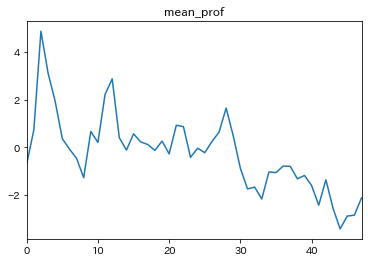

In [136]:
foot['mean_prof'].plot(title='mean_prof')
# やっぱ普通に5本がベスト

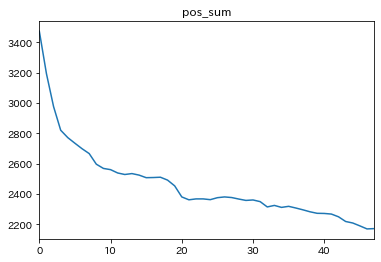

In [138]:
foot['pos_sum'].plot(title='pos_sum')

### 足の長さを変えてみる

In [16]:
foot_gran = pd.DataFrame(columns=['year', 'gran', 'pos_count', 'profit'])
for i in range(10, 20):
    for gran in ['M10', 'H1', 'H4', 'D']:
        pos_count, profit = back_test(2.0, 5000, 2000+i, 1, 1, 5, gran)
        print('year: {}, gran: {}, pos_count: {}, profit: {}'.format(2000+i, gran, pos_count, profit))
        tmp_se = pd.Series( [2000+i, gran, pos_count, profit ], index=foot_gran.columns )
        foot_gran = foot_gran.append( tmp_se, ignore_index=True )

year: 2010, gran: M10, pos_count: 259, profit: 3.6410000000001608
year: 2010, gran: H1, pos_count: 297, profit: 7.433999999999945
year: 2010, gran: H4, pos_count: 403, profit: -17.07199999999992
year: 2010, gran: D, pos_count: 167, profit: 12.544999999999984
year: 2011, gran: M10, pos_count: 287, profit: -1.7940000000001497
year: 2011, gran: H1, pos_count: 378, profit: -2.2400000000000704
year: 2011, gran: H4, pos_count: 397, profit: -7.266999999999899
year: 2011, gran: D, pos_count: 139, profit: 26.943000000000037
year: 2012, gran: M10, pos_count: 343, profit: -0.4520000000000399
year: 2012, gran: H1, pos_count: 311, profit: -3.7170000000000885
year: 2012, gran: H4, pos_count: 270, profit: 22.096000000000004
year: 2012, gran: D, pos_count: 100, profit: 26.853
year: 2013, gran: M10, pos_count: 273, profit: -2.3800000000000834
year: 2013, gran: H1, pos_count: 311, profit: 13.020999999999983
year: 2013, gran: H4, pos_count: 262, profit: 22.730000000000093
year: 2013, gran: D, pos_count: 

In [22]:
foot_gran.sort_values(by='profit', ascending=False).head(10)

,year,gran,pos_count,profit
18,2014,H4,256,42.317
22,2015,H4,236,30.453
7,2011,D,139,26.943
11,2012,D,100,26.853
26,2016,H4,206,24.502
14,2013,H4,262,22.730
10,2012,H4,270,22.096
25,2016,H1,294,18.656
15,2013,D,73,14.576
13,2013,H1,311,13.021


In [25]:
# 係数K を1.5にしてみる
foot_gran = pd.DataFrame(columns=['year', 'gran', 'pos_count', 'profit'])
for i in range(10, 20):
    for gran in ['M10', 'H1', 'H4', 'D']:
        pos_count, profit = back_test(1.5, 5000, 2000+i, 1, 1, 5, gran)
        tmp_se = pd.Series( [2000+i, gran, pos_count, profit ], index=foot_gran.columns )
        foot_gran = foot_gran.append( tmp_se, ignore_index=True )

In [26]:
foot_gran.sort_values(by='profit', ascending=False).head(10)

,year,gran,pos_count,profit
18,2014,H4,526,40.753
26,2016,H4,488,29.096
14,2013,H4,538,26.186
13,2013,H1,607,22.783
22,2015,H4,520,21.928
10,2012,H4,557,20.786
25,2016,H1,627,20.636
31,2017,D,64,13.787
30,2017,H4,441,11.898
34,2018,H4,285,10.596


In [40]:
foot_gran = pd.DataFrame(columns=['year', 'gran', 'pos_count', 'profit'])
for i in range(10, 20):
    for gran in ['S5', 'S10', 'S15', 'S30',
                 'M1', 'M2', 'M3', 'M4', 'M5', 'M10', 'M15', 'M30',
                 'H1', 'H2', 'H3', 'H4', 'H6', 'H8', 'H12',
                 'D']:
        pos_count, profit = back_test(2.0, 5000, 2000+i, 1, 1, 5, gran)
        print('year: {}, gran: {}, pos_count: {}, profit: {}'.format(2000+i, gran, pos_count, profit))
        tmp_se = pd.Series( [2000+i, gran, pos_count, profit ], index=foot_gran.columns )
        foot_gran = foot_gran.append( tmp_se, ignore_index=True )

year: 2010, gran: S5, pos_count: 926, profit: -3.7600000000000695
year: 2010, gran: S10, pos_count: 804, profit: -3.963000000000127
year: 2010, gran: S15, pos_count: 754, profit: -2.609000000000003
year: 2010, gran: S30, pos_count: 633, profit: -1.701000000000044
year: 2010, gran: M1, pos_count: 492, profit: -1.603999999999615
year: 2010, gran: M2, pos_count: 382, profit: -2.935999999999984
year: 2010, gran: M3, pos_count: 358, profit: -1.9069999999999112
year: 2010, gran: M4, pos_count: 317, profit: -3.569000000000063
year: 2010, gran: M5, pos_count: 290, profit: 1.3489999999999212
year: 2010, gran: M10, pos_count: 259, profit: 3.6410000000001608
year: 2010, gran: M15, pos_count: 273, profit: -2.021
year: 2010, gran: M30, pos_count: 284, profit: -4.685000000000058
year: 2010, gran: H1, pos_count: 297, profit: 7.433999999999945
year: 2010, gran: H2, pos_count: 378, profit: -1.0799999999999912
year: 2010, gran: H3, pos_count: 405, profit: -33.22399999999991
year: 2010, gran: H4, pos_cou

year: 2016, gran: M3, pos_count: 194, profit: 0.6810000000000596
year: 2016, gran: M4, pos_count: 187, profit: 0.0030000000000098906
year: 2016, gran: M5, pos_count: 182, profit: 2.026000000000013
year: 2016, gran: M10, pos_count: 204, profit: -1.2960000000001077
year: 2016, gran: M15, pos_count: 220, profit: 1.2540000000000404
year: 2016, gran: M30, pos_count: 272, profit: 1.267000000000099
year: 2016, gran: H1, pos_count: 294, profit: 18.65600000000011
year: 2016, gran: H2, pos_count: 260, profit: 18.67400000000001
year: 2016, gran: H3, pos_count: 247, profit: 27.701999999999966
year: 2016, gran: H4, pos_count: 206, profit: 24.502000000000134
year: 2016, gran: H6, pos_count: 176, profit: 17.97900000000006
year: 2016, gran: H8, pos_count: 101, profit: -26.269999999999943
year: 2016, gran: H12, pos_count: 64, profit: 2.963999999999942
year: 2016, gran: D, pos_count: 37, profit: 10.928000000000019
year: 2017, gran: S5, pos_count: 863, profit: -4.795999999999981
year: 2017, gran: S10, po

In [41]:
foot_gran.sort_values(by='profit', ascending=False).head(20)

,year,gran,pos_count,profit
114,2015,H3,262,45.726
95,2014,H4,256,42.317
58,2012,H12,173,41.395
18,2010,H12,285,40.151
38,2011,H12,267,34.033
115,2015,H4,236,30.453
96,2014,H6,221,30.426
78,2013,H12,135,30.256
134,2016,H3,247,27.702
76,2013,H6,236,27.019


### 4時間足を固定して係数もう一回チェック

In [31]:
api_refresh()
p_l = pd.DataFrame(columns=['K', '総ポジション数', '損益'])
for i in range(1, 50+1):
    K = round(i * 0.1, 1)
    pos_cou_list = []
    profit_sum_list = []
    for j in range(10, 20):
        pos_count, profit = back_test(K=K, count=5000, year=2000+j, month=1, day=1, ref=5, gran='H4')
        pos_cou_list.append(pos_count)
        profit_sum_list.append(profit)
    print('K={},  総ポジション数: {}, 総損益: {}'.format(K, sum(pos_cou_list), sum(profit_sum_list)))
    tmp_se = pd.Series( [ K, sum(pos_cou_list), sum(profit_sum_list) ], index=p_l.columns )
    p_l = p_l.append( tmp_se, ignore_index=True )

K=0.1,  総ポジション数: 42343, 総損益: -141.05099999999294
K=0.2,  総ポジション数: 41901, 総損益: -136.4089999999931
K=0.3,  総ポジション数: 39691, 総損益: -106.24199999999503
K=0.4,  総ポジション数: 35566, 総損益: -105.48699999999458
K=0.5,  総ポジション数: 30401, 総損益: -138.73099999999388
K=0.6,  総ポジション数: 25278, 総損益: -56.122999999997965
K=0.7,  総ポジション数: 20764, 総損益: -52.432999999996824
K=0.8,  総ポジション数: 17095, 総損益: 45.59900000000146
K=0.9,  総ポジション数: 14015, 総損益: 44.409000000001384
K=1.0,  総ポジション数: 11466, 総損益: 94.4450000000023
K=1.1,  総ポジション数: 9522, 総損益: 141.5050000000023
K=1.2,  総ポジション数: 8002, 総損益: 147.65600000000208
K=1.3,  総ポジション数: 6773, 総損益: 215.25100000000003
K=1.4,  総ポジション数: 5706, 総損益: 210.01800000000014
K=1.5,  総ポジション数: 4864, 総損益: 143.91600000000085
K=1.6,  総ポジション数: 4210, 総損益: 129.30600000000052
K=1.7,  総ポジション数: 3628, 総損益: 133.71900000000008
K=1.8,  総ポジション数: 3082, 総損益: 164.9920000000005
K=1.9,  総ポジション数: 2722, 総損益: 178.65000000000043
K=2.0,  総ポジション数: 2398, 総損益: 96.20600000000067
K=2.1,  総ポジション数: 2121, 総損益: 139.74100000000016
K=2

In [33]:
p_l.sort_values(by='損益', ascending=False).head(10)

,K,総ポジション数,損益
12,1.3,6773.0,215.251
13,1.4,5706.0,210.018
18,1.9,2722.0,178.650
17,1.8,3082.0,164.992
11,1.2,8002.0,147.656
14,1.5,4864.0,143.916
10,1.1,9522.0,141.505
20,2.1,2121.0,139.741
16,1.7,3628.0,133.719
15,1.6,4210.0,129.306


In [45]:
# 12時間足
p_l = pd.DataFrame(columns=['K', '総ポジション数', '損益'])
for i in range(1, 50+1):
    K = round(i * 0.1, 1)
    pos_cou_list = []
    profit_sum_list = []
    for j in range(10, 20):
        pos_count, profit = back_test(K=K, count=5000, year=2000+j, month=1, day=1, ref=5, gran='H12')
        pos_cou_list.append(pos_count)
        profit_sum_list.append(profit)
    print('K={},  総ポジション数: {}, 総損益: {}'.format(K, sum(pos_cou_list), sum(profit_sum_list)))
    tmp_se = pd.Series( [ K, sum(pos_cou_list), sum(profit_sum_list) ], index=p_l.columns )
    p_l = p_l.append( tmp_se, ignore_index=True )

K=0.1,  総ポジション数: 27402, 総損益: 254.5569999999892
K=0.2,  総ポジション数: 27145, 総損益: 229.44699999998906
K=0.3,  総ポジション数: 26116, 総損益: 327.46299999999206
K=0.4,  総ポジション数: 23437, 総損益: 412.1389999999964
K=0.5,  総ポジション数: 20024, 総損益: 583.1590000000077
K=0.6,  総ポジション数: 16894, 総損益: 496.3640000000002
K=0.7,  総ポジション数: 14216, 総損益: 335.01899999999915
K=0.8,  総ポジション数: 11524, 総損益: 244.7190000000001
K=0.9,  総ポジション数: 9363, 総損益: 258.99299999999965
K=1.0,  総ポジション数: 7598, 総損益: 204.54700000000287
K=1.1,  総ポジション数: 6112, 総損益: 199.6330000000012
K=1.2,  総ポジション数: 5089, 総損益: 158.1670000000006
K=1.3,  総ポジション数: 4004, 総損益: 157.9399999999999
K=1.4,  総ポジション数: 3303, 総損益: 177.1389999999991
K=1.5,  総ポジション数: 2605, 総損益: 99.19099999999979
K=1.6,  総ポジション数: 2261, 総損益: 149.858
K=1.7,  総ポジション数: 1882, 総損益: 79.46099999999961
K=1.8,  総ポジション数: 1563, 総損益: 115.85299999999992
K=1.9,  総ポジション数: 1387, 総損益: 222.15299999999942
K=2.0,  総ポジション数: 1208, 総損益: 180.95699999999954
K=2.1,  総ポジション数: 1031, 総損益: 173.56499999999988
K=2.2,  総ポジション数: 895, 総損益: 

In [46]:
p_l.sort_values(by='損益', ascending=False).head(10)

,K,総ポジション数,損益
4,0.5,20024.0,583.159
5,0.6,16894.0,496.364
3,0.4,23437.0,412.139
6,0.7,14216.0,335.019
2,0.3,26116.0,327.463
8,0.9,9363.0,258.993
0,0.1,27402.0,254.557
7,0.8,11524.0,244.719
1,0.2,27145.0,229.447
25,2.6,528.0,225.657


# 検証やり直しいいいいいいいいいい！！！！！！！！！！！！！

In [ ]:
# APIから取得したレートをPandasのDataFrameへ（Time とは別にインデックスありVer）
def to_dataframe(r):
    data = []
    for raw in r.response['candles']:
        data.append([raw['time'], raw['volume'], raw['mid']['o'], raw['mid']['h'], raw['mid']['l'], raw['mid']['c']])

    # リストからPandas DataFrameへ変換
    df = pd.DataFrame(data)
    df.columns = ['Time', 'Volume', 'Open', 'High', 'Low', 'Close']
    df['Time'] = pd.to_datetime(df['Time'])
    for col in ['Open', 'High', 'Low', 'Close']:
        df[col] = df[col].apply(float)
    return df

In [77]:
def get_data(count, year, month, day, gran):
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    _from = datetime.datetime(year=year, month=month, day=day,
                              hour=12, minute=0, second=0).strftime(fmt)
    params = {
        "count": count,
        "granularity": gran,
        'from': _from
    }
    r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
    api.request(r)
    df = to_dataframe(r)
    return df

In [91]:
df = pd.DataFrame()
df1 = get_data(count=1, year=2018, month=1, day=1, gran='M10')
df2 = get_data(count=1, year=2018, month=1, day=2, gran='M10')
df = pd.concat([df1, df2])
df.tail()

,Time,Volume,Open,High,Low,Close
0,2018-01-01 22:00:00+00:00,140,112.666,112.687,112.630,112.637
0,2018-01-02 12:00:00+00:00,80,112.234,112.236,112.194,112.194


In [80]:
df.head()

,Time,Volume,Open,High,Low,Close
0,2018-01-01 22:00:00+00:00,140,112.666,112.687,112.630,112.637
1,2018-01-01 22:10:00+00:00,201,112.642,112.692,112.624,112.676
2,2018-01-01 22:20:00+00:00,272,112.674,112.674,112.606,112.626
3,2018-01-01 22:30:00+00:00,100,112.619,112.619,112.582,112.596
4,2018-01-01 22:40:00+00:00,32,112.599,112.608,112.589,112.592


In [92]:
def get_data_super(start, end, gran):
    # xxxx-xx-xx～xxxx-xx-xx の期間のデータを取得してデータフレームを返す
    s_year, s_month, s_day = start.split('-')
    e_year, e_month, e_day = end.split('-')
    
    df = pd.DataFrame()
    
    i = True
    while i:
        df_tmp = get_data(count=1, year=s_year, month=s_month, day=s_day, gran=gran)
        df = pd.concat([df, df_tmp])
        
        
        
        # 日付が end に達したら終了
        year = df.iat[len(df.index)-1, 0].year
        month = df.iat[len(df.index)-1, 0].month
        day = df.iat[len(df.index)-1, 0].day
        date = '{}-{}-{}'.format(year, month, day)
        if date == end:
            i = False
    
    return df

In [87]:
df.iat[len(df.index)-1, 0]

Timestamp('2018-02-19 15:10:00+0000', tz='UTC')

In [81]:
df.iat[0, 0]

Timestamp('2018-01-01 22:00:00+0000', tz='UTC')

In [96]:
df = get_data_super(start='2018-01-01', end='2018-12-31', gran='M30')

NameError: name 's_year' is not defined